CHECKING OUTLIERS AND DROPPING IT

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Load the dataset
df = pd.read_csv('mimic_readmission_features.csv')

#  detect outliers using IQR method
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()

# detect outliers using Z-score method
def detect_outliers_zscore(column, threshold=3):
    z_scores = np.abs(stats.zscore(column.dropna()))
    return (z_scores > threshold).sum()

# Identify numeric columns (excluding categorical and binary columns)
numeric_columns = df.select_dtypes(include=[np.number]).columns
# Remove binary columns (0/1 values) and ID columns
numeric_columns = [col for col in numeric_columns if col not in [
    'HADM_ID', 'SUBJECT_ID', 'READMIT_30', 'HAD_ED_VISIT', 
    'CHARLSON_MI', 'CHARLSON_CHF', 'CHARLSON_PVD', 'CHARLSON_CVD',
    'CHARLSON_DEMENTIA', 'CHARLSON_COPD', 'CHARLSON_RHEUM', 'CHARLSON_PUD',
    'CHARLSON_LIVER_MILD', 'CHARLSON_DM', 'CHARLSON_DM_COMP', 'CHARLSON_PLEGIA',
    'CHARLSON_RENAL', 'CHARLSON_CANCER', 'CHARLSON_LIVER_SEV', 'CHARLSON_METS',
    'CHARLSON_AIDS', 'HAS_HEART_FAILURE', 'HAS_PNEUMONIA', 'HAS_AMI',
    'HAS_COPD_EXACERB', 'HAS_SEPSIS', 'HAS_STROKE', 'HAS_RENAL_FAILURE',
    'HAS_GI_BLEED', 'HAS_DIABETES_COMP', 'HAS_PSYCHIATRIC', 'HEMOGLOBIN_ABNORMAL',
    'CREATININE_ABNORMAL', 'BUN_ABNORMAL', 'GLUCOSE_ABNORMAL', 'SODIUM_ABNORMAL',
    'POTASSIUM_ABNORMAL', 'WBC_ABNORMAL', 'PLATELET_ABNORMAL', 'LACTATE_ABNORMAL',
    'HAS_ANTICOAGULANTS', 'HAS_DIURETICS', 'HAS_INSULIN', 'HAS_OPIOIDS',
    'HAS_STEROIDS', 'HAS_ANTIBIOTICS', 'POLYPHARMACY', 'FREQUENT_FLYER'
]]

print("Analyzing outliers in numeric columns...")
print("-" * 50)

# Analyze outliers using both methods
outlier_stats = []
for col in numeric_columns:
    if df[col].nunique() > 10:  # Only consider columns with sufficient variability
        iqr_outliers = detect_outliers_iqr(df[col])
        zscore_outliers = detect_outliers_zscore(df[col])
        outlier_percentage = max(iqr_outliers, zscore_outliers) / len(df) * 100
        
        outlier_stats.append({
            'Column': col,
            'IQR_Outliers': iqr_outliers,
            'ZScore_Outliers': zscore_outliers,
            'Max_Outliers': max(iqr_outliers, zscore_outliers),
            'Outlier_Percentage': outlier_percentage
        })

# Create DataFrame with outlier statistics
outlier_df = pd.DataFrame(outlier_stats)
outlier_df = outlier_df.sort_values('Outlier_Percentage', ascending=False)

print("Columns with highest percentage of outliers:")
print(outlier_df.head(10))

# Identify columns with more than 5% outliers
high_outlier_cols = outlier_df[outlier_df['Outlier_Percentage'] > 5]['Column'].tolist()
print(f"\nColumns with >5% outliers: {high_outlier_cols}")

# Remove rows with outliers in multiple columns
print("\nRemoving rows with excessive outliers...")

# Calculate outlier scores for each row
df_clean = df.copy()
outlier_flags = pd.DataFrame(index=df.index)

for col in high_outlier_cols:
    # Use Z-score method for outlier detection
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    outlier_mask = pd.Series(False, index=df.index)
    outlier_mask[df[col].dropna().index] = z_scores > 3
    outlier_flags[col] = outlier_mask

# Count number of outlier columns per row
outlier_flags['outlier_count'] = outlier_flags.sum(axis=1)

# Remove rows with outliers in more than 2 columns
rows_to_remove = outlier_flags[outlier_flags['outlier_count'] > 2].index
df_clean = df_clean.drop(rows_to_remove)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Rows removed: {len(rows_to_remove)}")

# Save the cleaned dataset
cleaned_dataset = df_clean
cleaned_dataset.to_csv('outlier_removed.csv', index=False)
print("Cleaned dataset also saved to 'outlier_removed.csv'")

Analyzing outliers in numeric columns...
--------------------------------------------------
Columns with highest percentage of outliers:
                      Column  IQR_Outliers  ZScore_Outliers  Max_Outliers  \
5            TOTAL_DIAGNOSES         10000             1263         10000   
6    NUM_SECONDARY_DIAGNOSES          9950             1263          9950   
9  DAYS_SINCE_LAST_ADMISSION          8750             1370          8750   
4             CHARLSON_SCORE          5491             1074          5491   
3         MAX_ICU_STAY_HOURS          5483              919          5483   
2        TOTAL_ICU_LOS_HOURS          5382              929          5382   
8        PREVIOUS_ADMISSIONS          4246              641          4246   
7          TOTAL_MEDICATIONS          4192             1085          4192   
1          HOSPITAL_LOS_DAYS          3741              943          3741   
0         HOSPITAL_LOS_HOURS          3741              943          3741   

   Outlier_Perc

BALANCING THE SAMPLE WITH SMOTE

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('outlier_removed.csv')
    print("Successfully loaded 'final_dataset_no_outliers.csv'.")
except FileNotFoundError:
    print("Error: 'final_dataset_no_outliers.csv' not found. Please ensure the file exists.")
    exit()

# Drop identifier columns and columns with too many missing values or irrelevant for this task
df = df.drop(columns=['PRIMARY_DIAGNOSIS', 'LOS_CATEGORY'])

# Separate features (X) and target (y)
X = df.drop(columns=['READMIT_30'])
y = df['READMIT_30']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

# --- Impute missing values ---
# For numerical columns, fill with the mean
num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# For categorical columns, fill with the most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
print("Missing values have been successfully imputed.")

# ---  Encode categorical variables ---
# Convert categorical string values into a numerical format
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
print("Categorical variables have been label encoded.")


# ---  Apply SMOTE to handle class imbalance ---
print("\nOriginal dataset shape: {}".format(Counter(y)))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Resampled dataset shape: {}".format(Counter(y_resampled)))

# Create a new DataFrame with the balanced data
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['READMIT_30'] = y_resampled

# Save the balanced dataset to a new CSV file
output_filename = 'SMOTE_applied.csv'
balanced_df.to_csv(output_filename, index=False)

print(f"\n✅ Balanced dataset saved to '{output_filename}'")

Successfully loaded 'final_dataset_no_outliers.csv'.
Missing values have been successfully imputed.
Categorical variables have been label encoded.

Original dataset shape: Counter({False: 41545, True: 2893})
Resampled dataset shape: Counter({False: 41545, True: 41545})

✅ Balanced dataset saved to 'SMOTE_applied.csv'


FEATURE CORRELATION

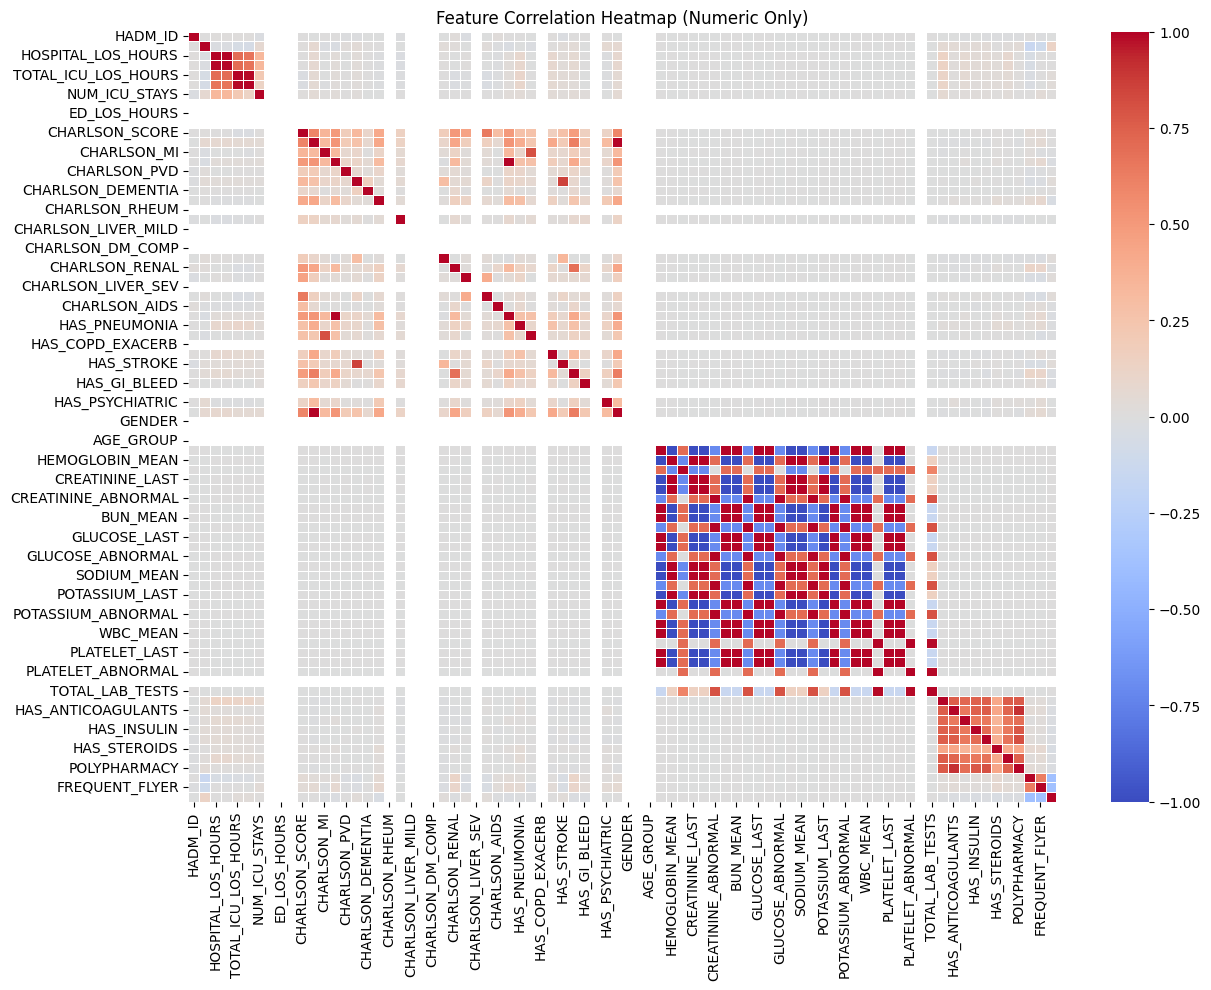

Columns to drop (high correlation > 0.85):
{'PLATELET_LAST', 'POTASSIUM_MEAN', 'TOTAL_LAB_TESTS', 'HOSPITAL_LOS_DAYS', 'CREATININE_MEAN', 'GLUCOSE_MEAN', 'WBC_LAST', 'PLATELET_ABNORMAL', 'SODIUM_ABNORMAL', 'SODIUM_LAST', 'WBC_MEAN', 'HAS_STROKE', 'HEMOGLOBIN_MEAN', 'BUN_MEAN', 'GLUCOSE_LAST', 'POTASSIUM_LAST', 'SODIUM_MEAN', 'GLUCOSE_ABNORMAL', 'MAX_ICU_STAY_HOURS', 'NUM_SECONDARY_DIAGNOSES', 'HAS_HEART_FAILURE', 'POLYPHARMACY', 'PLATELET_MEAN', 'BUN_LAST', 'POTASSIUM_ABNORMAL', 'CREATININE_LAST', 'BUN_ABNORMAL'}


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('SMOTE_applied.csv')

# Drop target column
df_features = df.drop(columns=["READMIT_30"])

# Select only numeric columns
df_numeric = df_features.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap (Numeric Only)")
plt.show()

# -----------------------------
# Drop highly correlated columns
# -----------------------------
threshold = 0.85
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

print("Columns to drop (high correlation > 0.85):")
print(to_drop)




FINDING TOP 20 IMPORTANT FEATURES FOR PREDICTION

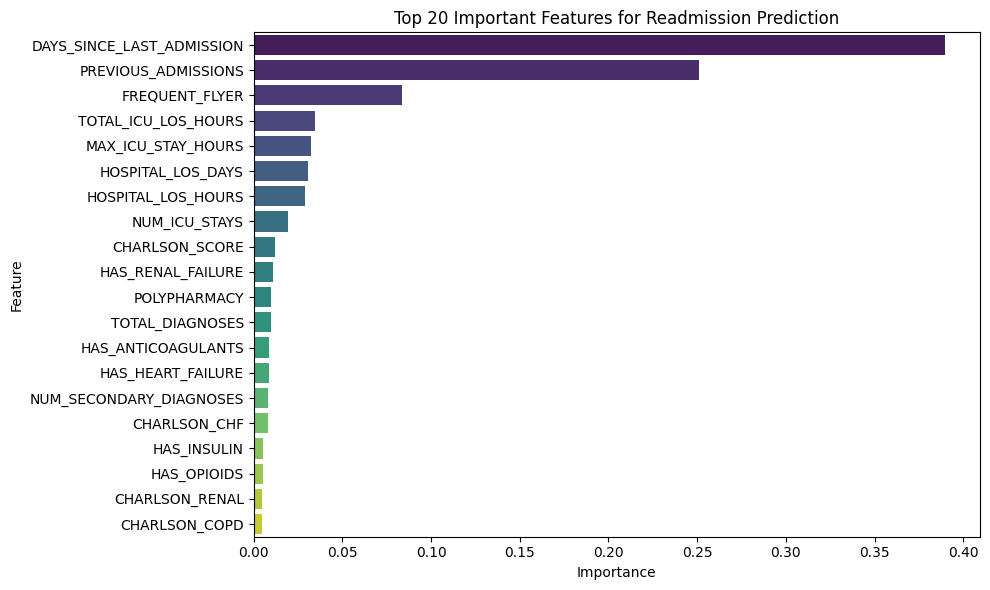

In [25]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = 'SMOTE_applied.csv'
df = pd.read_csv(file_path)

# Drop ID-like and datetime columns
drop_cols = ['HADM_ID', 'SUBJECT_ID', 'dob', 'ADMITTIME', 'DISCHTIME']
df_model = df.drop(columns=drop_cols, errors='ignore')

# Features (X) and Target (y)
X = df_model.drop(columns=['READMIT_30'])
y = df_model['READMIT_30']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
features = X.columns
feat_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette="viridis")
plt.title("Top 20 Important Features for Readmission Prediction")
plt.tight_layout()
plt.show()


FEATURE CORRELATION AFTER DROPPING UNCORRELATED COLUMNS FOR PREDICTION

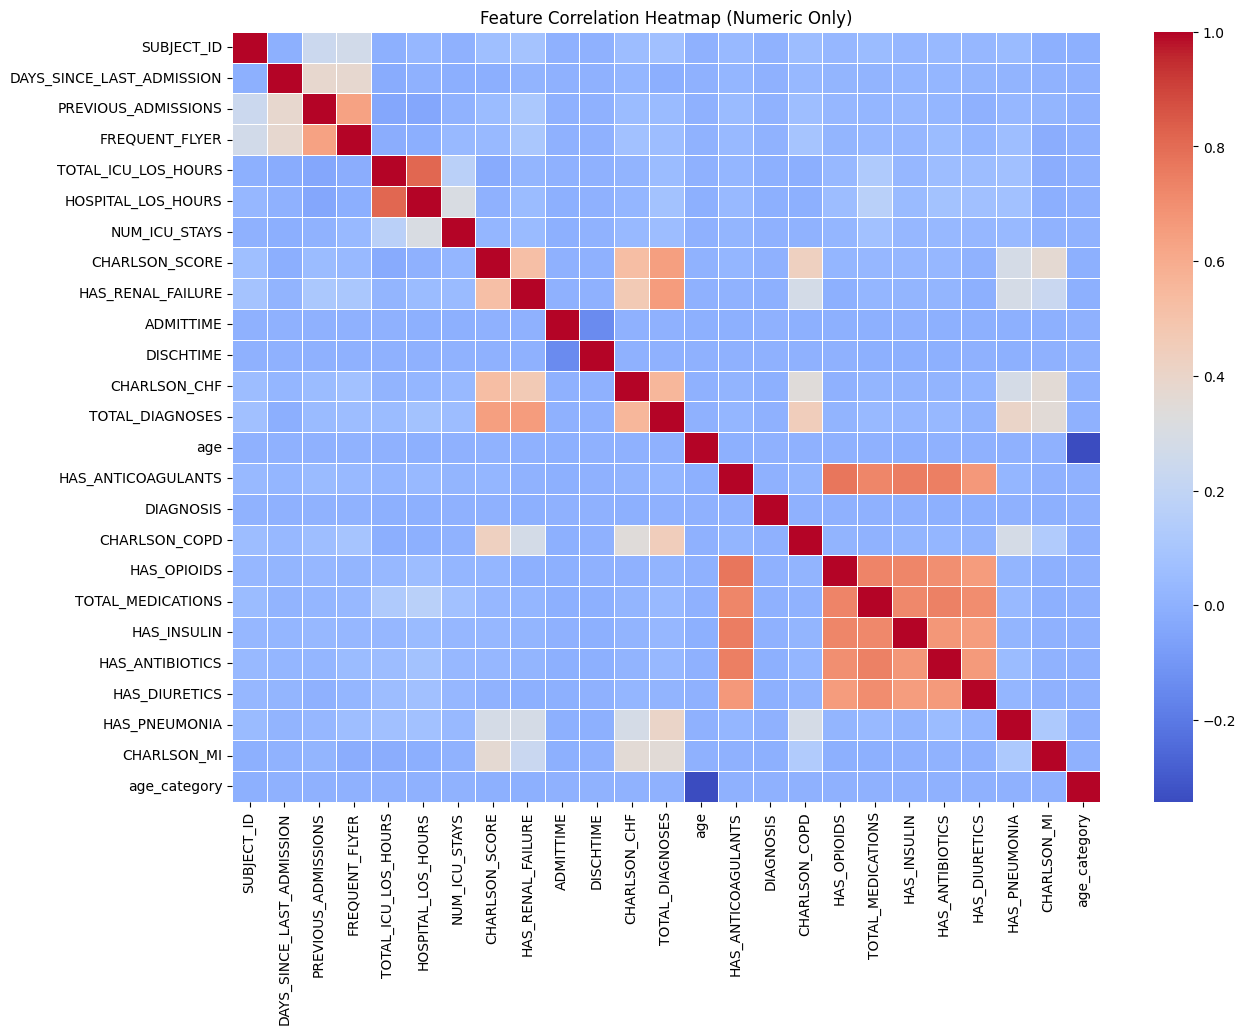

Columns to drop (high correlation > 0.85):
set()


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('important_features.csv')

# Drop target column
df_features = df.drop(columns=["READMIT_30"])

# Select only numeric columns
df_numeric = df_features.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap (Numeric Only)")
plt.show()

# -----------------------------
# Drop highly correlated columns
# -----------------------------
threshold = 0.85
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

print("Columns to drop (high correlation > 0.85):")
print(to_drop)




CHECKING BASIC DESCRIPTION OF THE FINAL DATASET

In [27]:
import pandas as pd

# Load dataset
file_path = 'important_features.csv'
df = pd.read_csv(file_path)

print("========== BASIC INFO ==========")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:")
print(df.columns.tolist())

print("\n========== DATA TYPES ==========")
print(df.dtypes)

print("\n========== MISSING VALUES ==========")
print(df.isnull().sum().sort_values(ascending=False).head(20))  # Top 20 columns with most missing values

print("\n========== DUPLICATES ==========")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

print("\n========== DESCRIPTIVE STATISTICS ==========")
print(df.describe(include='all').transpose().head(20))  # First 20 columns summary


========== BASIC INFO ==========
Number of rows: 85226
Number of columns: 26

Column names:
['SUBJECT_ID', 'DAYS_SINCE_LAST_ADMISSION', 'PREVIOUS_ADMISSIONS', 'FREQUENT_FLYER', 'TOTAL_ICU_LOS_HOURS', 'HOSPITAL_LOS_HOURS', 'NUM_ICU_STAYS', 'CHARLSON_SCORE', 'HAS_RENAL_FAILURE', 'ADMITTIME', 'DISCHTIME', 'CHARLSON_CHF', 'TOTAL_DIAGNOSES', 'age', 'HAS_ANTICOAGULANTS', 'DIAGNOSIS', 'CHARLSON_COPD', 'HAS_OPIOIDS', 'TOTAL_MEDICATIONS', 'HAS_INSULIN', 'HAS_ANTIBIOTICS', 'HAS_DIURETICS', 'HAS_PNEUMONIA', 'CHARLSON_MI', 'age_category', 'READMIT_30']

========== DATA TYPES ==========
SUBJECT_ID                   float64
DAYS_SINCE_LAST_ADMISSION    float64
PREVIOUS_ADMISSIONS          float64
FREQUENT_FLYER               float64
TOTAL_ICU_LOS_HOURS          float64
HOSPITAL_LOS_HOURS           float64
NUM_ICU_STAYS                float64
CHARLSON_SCORE               float64
HAS_RENAL_FAILURE            float64
ADMITTIME                      int64
DISCHTIME                      int64
CHARLSON_CHF